In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_palette('magma_r')

## MNIST :

We're using the MNIST Dataset in this chapter, which consists of 70,000 images, where each image has 784 features (28 x 28 pixels), each representing the intensity of the pixel ranging from 0 to 255. Since, MNIST is one among the popular datasets, it can be imported directly from scikit-learn as shown below.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


	Label: 5


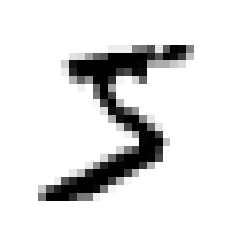

In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

print('\tLabel:', y[0])
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

Each image has a label which tells us what the digit actually is and this case we can see that both the image and the label tell us that it's 5. The labels are originally strings so we type cast them to integers as shown.

In [5]:
print(type(y[0]))
y = y.astype(np.uint8)
print(type(y[0]))

<class 'str'>
<class 'numpy.uint8'>


Let's have a look at some more examples (100-200)

In [6]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis('off')

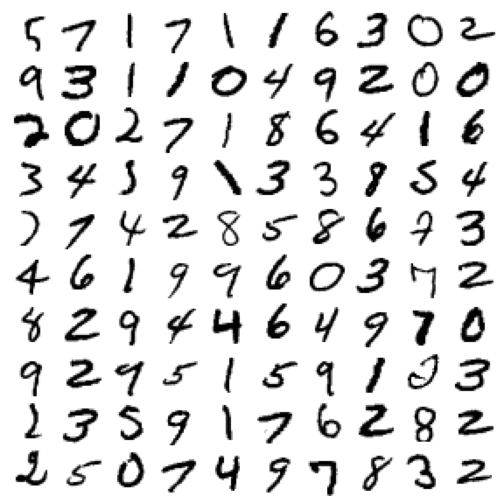

In [7]:
plt.figure(figsize=(9, 9))
example_images = X[100:200]
plot_digits(example_images, images_per_row=10)
plt.show()

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Splitting the test set from the data. (In MNIST Dataset, test set is set as the last 10,000 images and hence, the first 60,000 act as the train split which are already shuffled)

## Binary Classifier (5-Detector) :

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Now that we have created target vectors for both training and testing, we start training the classifiers starting from Stochastic Gradient Descent (SGD) which is capable of handling large datasets efficiently.

In [10]:
from sklearn.linear_model import SGDClassifier

# max_iter and tol are explicitly set to avoid version errors
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
# some_digit is (X[0]) = 5
sgd_clf.predict([some_digit])

array([ True])

## Performance Measurement :

### Cross-Validation :

The classifier was able to tell that the image represented the digit 5 but to evaluate the accuracy we need performance measures. First, we start with the cross-validation score (first version is the general implementation of the second)

In [12]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


The StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

We get an accuracy of above 95% on all cross-validation folds. Below we've made a classifier that predicts all images as not-5 and check the accuracy.

In [14]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Even by classifying all images as not-5, we get an accuracy of above 90% in all the three folds. This happens because only 10% of the images represent the digit 5, so even if we assume that no image represents 5, we are right almost 90% of the times. This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when we are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

### Confusion Matrix :

The general idea behind confusion matrix is to count the number of times instances of class A were wrongly classified as class B. To compute the confusion matrix, we need a set of predictions and a set of actual targets values to be compared with.

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

The cross_val_predict() function performs K-fold Cross-Validation on the sets, but instead of returning evaluation scores (cross_val_score), it returns the predictions made on each of the test folds.

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

- Each row represents an actual class
- Each column represents a predicted class

| |**Col_01**|**Col_02**|
|-|-----|-----|
|**Row_01**|True Negatives|False Positives|
|**Row_02**|False Negatives|True Positives|

- TN = 53,892 were correctly classified as non-5s
- FP = 687 were wrongly classified as 5s
- FN = 1891 were wrongly classified as non-5s
- TP = 3530 were correctly classified as 5s

In [18]:
# For perferct predictions
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

Now that we have the count, we can try and find how close the predictions were to the actual targets and this can be done by looking at the accuracy of positive predictions (Precision of the classifier).

- **Precision = TP / (TP + FP)**
- **Recall = TP / (TP + FN)**

Along with precision we often use another metric known as Recall, which is also known as senstivity or true-positive-rate and this metric gives the ratio of positive instances that are correctly detected by the classifier.

In [19]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) # 3530 / (3530 + 687)
print(recall_score(y_train_5, y_train_pred)) # 3530 / (3530 + 1891)

0.8370879772350012
0.6511713705958311


We often combine the Precision and Recall scores and denote it as one single metric known as the F1 score, which is the harmonic mean of both, Precision and Recall. 

- **F1 = 2 / [ (1 / Precision) + (1 / Recall) ]**
- **F1 = 2 * [ (precision * recall) / (precision + recall) ]**
- **F1 = TP / TP + [ (FN + FP) / 2 ]**

Regular Mean treats all values equally, whereas the harmonic mean gives more weight to the low values. There would be a high F1 score only if both recall and precision have high values themselves.

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

We give weight to precision and recalls on the basis of the context in which they are being observed. Increasing precision reduces recall and vice versa and this comparison between precision and recall is known as the Precision/Recall Tradeoff.

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

[2164.22030239]


In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [23]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [25]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

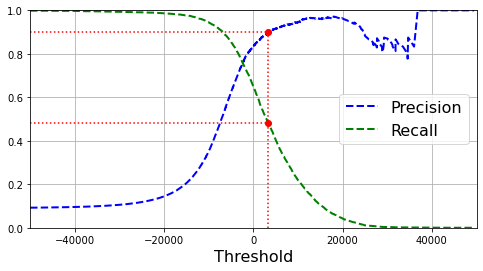

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

# np.argmax() returns 
# first index that has maxvalue (true) and precision >= 0.9
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

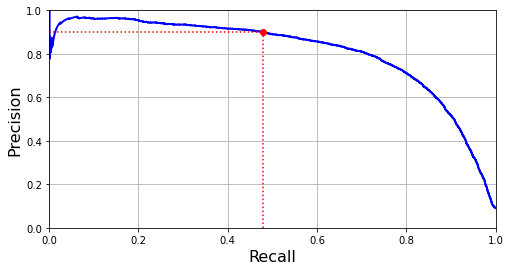

In [27]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize=(8, 4))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0, 0.9], "r:")
plt.plot([0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [28]:
print(threshold_90_precision)
print(recall_90_precision)

3370.0194991439594
0.4799852425751706


In [29]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [30]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


### ROC Curve :

ROC (Receiver-Operating-Characteristic) curve represents the plot between the true-positive-rate (recall) and the false-positive-rate (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. 

- **FPR = 1 - TNR**

Where, TNR is the true-negative-rate or the ratio of negative instances that are correctly classified as negative. TNR is also known as specificity. 

- **ROC Curve : TPR (recall) ---- vs ------- FPR (1 - TNR)**
- **ROC Curve : Senstivity ------- vs ------ (1 - Specificity)**

In [31]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

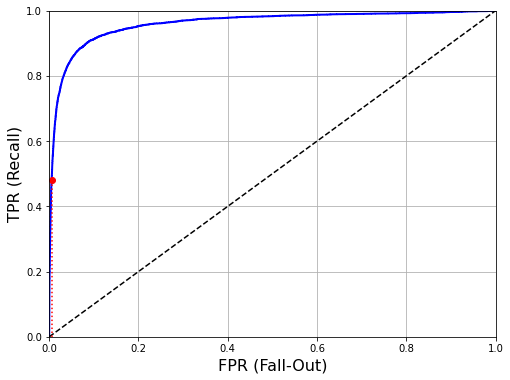

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, color="b", label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("FPR (Fall-Out)", fontsize=16)
    plt.ylabel("TPR (Recall)", fontsize=16)
    plt.grid(True)
    
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0, recall_90_precision], "r:")
plt.plot([0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

ROC Points to note :

- Higher the TPR, higher the FPR
- Dotted line represents ROC curve of purely random classifier
- A good classifier stays as far away from the dotted line as possible (towards top-left)

A metric to compare two ROC Curves is AUC (Area under the Curve).<br>
The perfect classifier will have an AUC of 1 whereas the random classifier will have the AUC of 0.5

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [35]:
y_scores_forest = y_probas_forest[:, 1] # proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

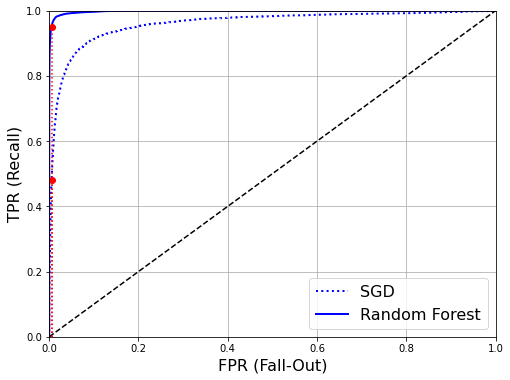

In [36]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0, recall_90_precision], "r:")
plt.plot([0, fpr_90], [recall_90_precision, recall_90_precision], "r:")

plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0, recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [38]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [39]:
print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))

0.9905083315756169
0.8662608374838591


## Multiclass Classification :

In [40]:
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto', random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [41]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [42]:
print("Best class prediction :", np.argmax(some_digit_scores))

Best class prediction : 5


In [43]:
sgd_clf.classes_

array([False,  True])

There are two strategies for Multiclass Classification :

- **One-versus-One (OVO)** :
    - N classes, N * (N - 1) / 2 Binary Classifiers
    - Classifiers in pair, 0-or-1, 1-or-2 and so on
    - Pick the class that has better score when compared to every other
    
    
- **One-versus-All/Rest (OVA/OVR)** : 
    - N classes, N different Binary Classifiers
    - For example, 0-detector, 1-detector and so on
    - Pick the class with the highest output score

In [44]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [45]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [46]:
print("OVO :", len(ovo_clf.estimators_))
print("OVR :", len(ovr_clf.estimators_))

OVO : 45
OVR : 10


In [47]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [48]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

The 5th index of the predict_proba array has the value of 0.9 indicating that the classifier is 90% sure that the digit passed is 5. The digits 2, 3 and 9 also have minute percentages. Note : The index of the array also represents the class (0th index for class-0 and 1st index for class-1 and so on)

In [49]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis :

In [51]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

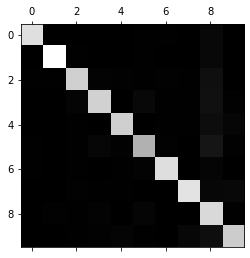

In [52]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [53]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

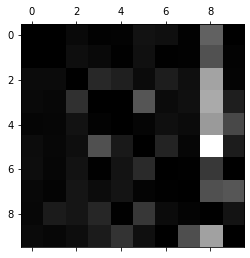

In [54]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Here the rows represent classes and the columns represent the predicted classes. The column for class 8 is quite bright, which tells us that many images get misclassified as 8s. However, the row for class 8 is not that bad, telling us that actual 8s in general get properly classified as 8s.

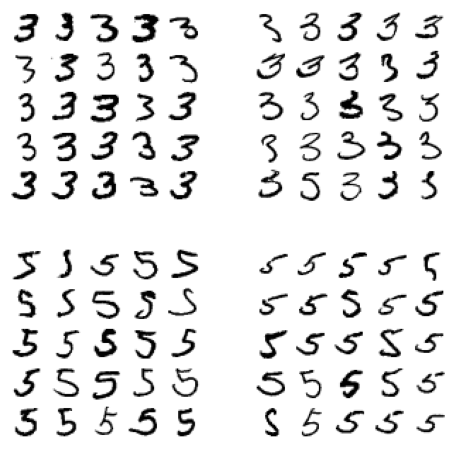

In [55]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification :

Classification systems that output multiple binary tags are called multilabel classification systems. The code below creates the multilabel array containing 2 target labels for each image: first indicates whether the digit is large and the second tells us if the digit is odd. With that, we run the K-Neighbors classifier and we get two binary outputs for each of the target labels.

In [56]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [57]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [58]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## Multioutput Classification :

Generalization of multilabel classification where each label can be multiclass is called Multioutput classification. Here, the classifier's output is multilabeled (one label per pixel) and each label can have multiple values (0 to 255).

In [59]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [61]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
    plt.axis('off')

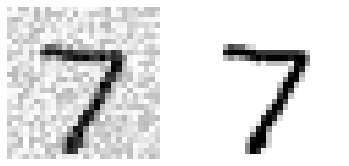

In [62]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

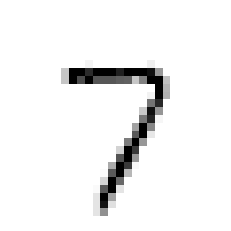

In [63]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

## Exercises :

### 1) MNIST-KNeighborsClassifier-with-GridSearchCV :

```python
from sklearn.model_selection import GridSearchCV
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)
```
* ```GridSearchCV(cv=5, estimator=KNeighborsClassifier(),```

    ```param_grid=[{'n_neighbors': [3, 4, 5], 'weights': ['uniform', 'distance']}], verbose=3)```

```python
grid_search.best_params_
```
* ```{'n_neighbors': 4, 'weights': 'distance'}```

```python
grid_search.best_score_
```
* ```0.9716166666666666```

```python
from sklearn.metrics import accuracy_score
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)
```
* ```0.9714``` (> 97%)

### 2) Data Augmentation :

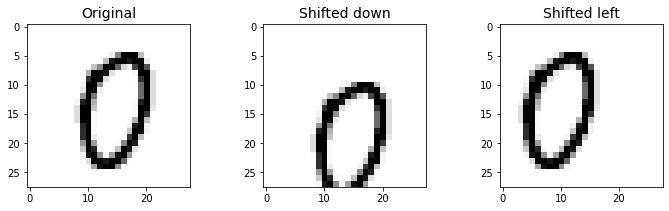

In [64]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])
    
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131); plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132); plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133); plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [66]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [67]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

* Since we did not run the GridSearch earlier, we are simulating the results.

```python
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)
```
* ```KNeighborsClassifier(n_neighbors=4, weights='distance')```

```python
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)
```
* ```0.9763```

*Note : Q3 and Q4 links in exercises.md*